# Nucleosome sequencing of Loxodes sorted nuclei

Sorted MIC vs. MAC, nucleosomal DNA was prepared by digestion of linker DNA with Atlantis dsDNase. Nucleosomal DNA (protected fragments) were mapped against MAC reference genome (Falcon assembly).

We want to visualize the following:

* Fragment sizes of digested nucleosomal DNA using merged reads (not dependent on mapping accuracy) 
* Fragment sizes from mapped reads (may be affected by misassembly or mismapping)
* Global phaseograms of nucleosomal reads to look for overall ordering of nucleosomes
* Phaseograms relative to gene features

In [1]:
from glob import glob
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import json
import gzip
%matplotlib inline

# Fragment sizes from merged reads

Check fragment size distribution from merged reads. This is independent of mapping, so should show the fragment size distribution without potential errors or artefacts from misassembly or mismapping, which are a potential issue when the genome is repeat-rich.

In [2]:
%%bash
head ../reads/lib_505_1L.ihist.txt

#Mean	135.440
#Median	140
#Mode	144
#STDev	24.675
#PercentOfPairs	73.024
#InsertSize	Count
35	20319
36	20465
37	21292
38	22453


In [3]:
mkdir -p plots

In [4]:
# Plot length distribution of merged reads, representing fragments < 200 bp (read library is 2x100 bp)

# Read data from histogram files produced by bbmerge.sh
dfs = []
for fn in glob('../reads/*.ihist.txt'):
    # Get sample information from filename
    pf = os.path.basename(fn).split('.')[0]
    df = pd.read_csv(fn,sep='\t',skiprows=6,names=['ins','count'])
    df['lib'] = pf
    # Suffixes U and L ('upper','lower') refer to MAC and MIC nuclei respectively
    if pf.endswith('L'):
        df['nuc'] = 'MIC'
    elif pf.endswith('U'):
        df['nuc'] = 'MAC'
    dfs.append(df)
dfs = pd.concat(dfs)

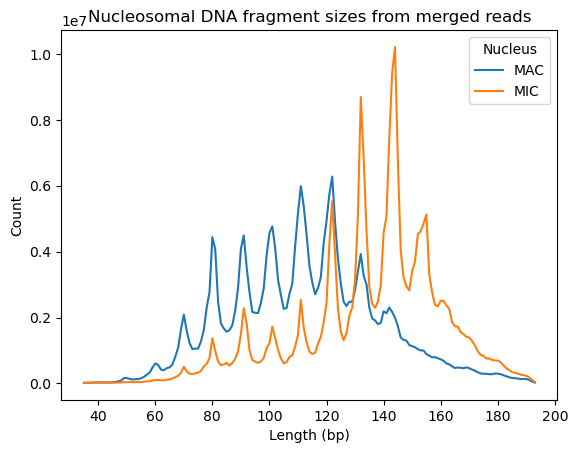

In [5]:
sns.lineplot(
    data=dfs,
    x='ins', y='count', hue='nuc', estimator=None
)
plt.title('Nucleosomal DNA fragment sizes from merged reads')
plt.xlabel('Length (bp)')
plt.ylabel('Count')
plt.legend(title='Nucleus')

plt.savefig('plots/merged_reads_length_distribution.png')
plt.savefig('plots/merged_reads_length_distribution.pdf')

Fragment sizes are higher for MIC (modally 150 bp) compared to MAC (120 bp). There is also a ~10 bp periodicity 
superimposed on top, which could represent the DNA helical turn.

# Phaseograms from read mappings against MAC assembly

In [6]:
# Use frag size 126 to 166 bp for MIC nucleosomal DNA
# and size 96 to 136 bp for MAC, because MAC has heavier digestion (from frag size plots)

# Import phaseograms relative to gene starts
pgs = []
for i in glob('../plots/*.126_166.*L.phaseogram.gene.json*') + glob('../plots/*.96_136.*U.phaseogram.gene.json*'):
    lib = os.path.basename(i).split('.')[2]
    typ = os.path.basename(i).split('.')[0]
    if i.endswith('.gz'):
        with gzip.open(i,'rt') as fh:
            pg = json.load(fh)
    else:
        with open(i, 'r') as fh:
            pg = json.load(fh)
    pg = [{'pos' : int(i), 'count' : int(pg[i])} for i in pg]
    pg = pd.DataFrame(pg)
    pg['typ'] = typ
    pg['lib'] = lib
    if lib.endswith('U'):
        pg['nuc'] = 'MAC'
    elif lib.endswith('L'):
        pg['nuc'] = 'MIC'
    pg = pg.sort_values('pos').reset_index()
    pgs.append(pg)
pgs = pd.concat(pgs)

In [7]:
# Import global phaseograms
pgs_global = []
for i in glob('../plots/*.126_166.*L.phaseogram_global.json*') + glob('../plots/*.96_136.*U.phaseogram_global.json*'):
    lib = os.path.basename(i).split('.')[2]
    typ = os.path.basename(i).split('.')[0]
    if i.endswith('.gz'):
        with gzip.open(i,'rt') as fh:
            pg = json.load(fh)
    else:
        with open(i, 'r') as fh:
            pg = json.load(fh)
    pg = [{'pos' : int(i), 'count' : int(pg[i])} for i in pg]
    pg = pd.DataFrame(pg)
    pg['typ'] = typ
    pg['lib'] = lib
    if lib.endswith('U'):
        pg['nuc'] = 'MAC'
    elif lib.endswith('L'):
        pg['nuc'] = 'MIC'
    pg = pg.sort_values('pos').reset_index()
    pgs_global.append(pg)
pgs_global = pd.concat(pgs_global)

In [8]:
# Template length histograms (cutoff values not relevant)
tln = []
for i in glob('../plots/*.126_166.*.tlen_hist.json*'):
    lib = os.path.basename(i).split('.')[2]
    typ = os.path.basename(i).split('.')[0]
    if i.endswith('.gz'):
        with gzip.open(i, 'rt') as fh:
            tl = json.load(fh)
    else:
        with open(i, 'r') as fh:
            tl = json.load(fh)
    tl = [{'pos' : int(i), 'count' : int(tl[i])} for i in tl]
    tl = pd.DataFrame(tl)
    tl['lib'] = lib
    tl['typ'] = typ
    if lib.endswith('U'):
        tl['nuc'] = 'MAC'
    elif lib.endswith('L'):
        tl['nuc'] = 'MIC'
    tl = tl.sort_values('pos').reset_index()
    tln.append(tl)
tln = pd.concat(tln)

In [9]:
# Convert counts to fractions of subtotals per library and low-complexity-repeat status
pgs['frac'] = pgs['count']/pgs.groupby(['lib','typ'])['count'].transform('sum')
pgs_global['frac'] = pgs_global['count']/pgs_global.groupby(['lib','typ'])['count'].transform('sum')
tln['frac'] = tln['count'] / tln.groupby('lib')['count'].transform('sum')

In [10]:
pgs.head()

,index,pos,count,typ,lib,nuc,frac
0,1066,-1000,15627,nonrep,lib_505_1L,MIC,0.000481
1,1342,-999,15422,nonrep,lib_505_1L,MIC,0.000475
2,1343,-998,15712,nonrep,lib_505_1L,MIC,0.000484
3,259,-997,15436,nonrep,lib_505_1L,MIC,0.000475
4,398,-996,16077,nonrep,lib_505_1L,MIC,0.000495


In [11]:
pgs_global.head()

,index,pos,count,typ,lib,nuc,frac
0,1161,-1000,1767988,sort,lib_505_1L,MIC,0.000442
1,160,-999,1769520,sort,lib_505_1L,MIC,0.000442
2,1,-998,1769355,sort,lib_505_1L,MIC,0.000442
3,1861,-997,1768262,sort,lib_505_1L,MIC,0.000442
4,2,-996,1767207,sort,lib_505_1L,MIC,0.000442


In [12]:
# Multiply fractions by 1e4 for less cluttered axis labels
pgs['frac_e4'] = pgs['frac'] * 1e4
pgs_global['frac_e4'] = pgs_global['frac'] * 1e4

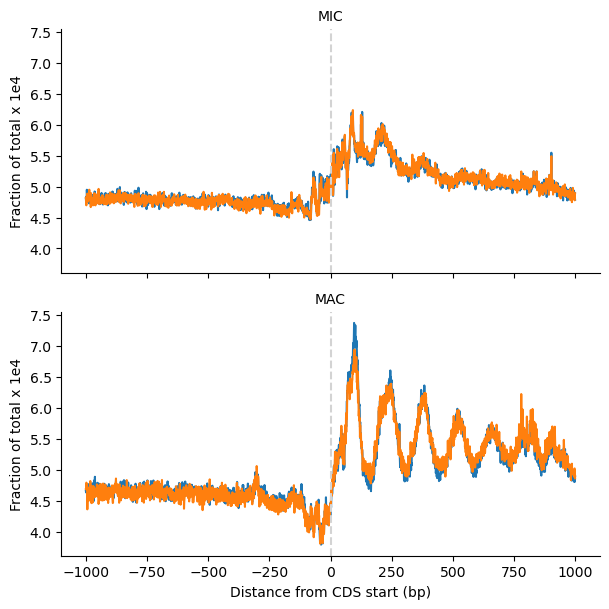

In [13]:
# Low-complexity sequences are masked during gene prediction 
# so we drop them when plotting phaseograms relative to gene features
g = sns.FacetGrid(
    data=pgs.query('typ == "nonrep"'), row='nuc', aspect=2)
g.map_dataframe(
    sns.lineplot,
    x='pos',
    y='frac_e4',
    hue='lib')
g.map(
    plt.axvline,
    x=0, linestyle='--', color='lightgrey')

g.tight_layout()
g.set_titles(template='{row_name}')
g.set_xlabels('Distance from CDS start (bp)')
g.set_ylabels('Fraction of total x 1e4')

g.savefig('plots/phaseogram_gene.combined.png')
g.savefig('plots/phaseogram_gene.combined.pdf')

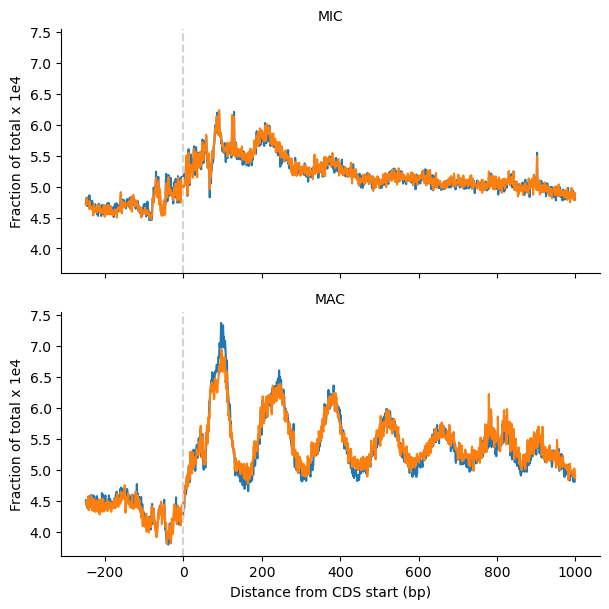

In [14]:
# Zoom in to see the details more clearly: is the ~10 bp periodicity noticeable in this plot too?
g = sns.FacetGrid(
    data=pgs.query('pos>-250 and typ == "nonrep"'), row='nuc', aspect=2)
g.map_dataframe(
    sns.lineplot,
    x='pos',
    y='frac_e4',
    hue='lib')
g.map(
    plt.axvline,
    x=0, linestyle='--', color='lightgrey')

g.tight_layout()
g.set_titles(template='{row_name}')
g.set_xlabels('Distance from CDS start (bp)')
g.set_ylabels('Fraction of total x 1e4')

g.savefig('plots/phaseogram_gene.combined.detail.png')
g.savefig('plots/phaseogram_gene.combined.detail.pdf')

Observations on phaseograms relative to CDS starts:
 * Noisy plots, probably because coverage is low
 * However, MAC has apparently well ordered nucleosomes relative to CDS starts, unlike MIC where no such pattern evident
 * Noisiness could also be attributed to use of CDS starts instead of true transcription start sites (TSSs), because we lack that data. We assume that CDS starts are close to TSSs, and that the difference between these two positions is relatively tightly distributed because this is the case in most ciliates. Nonetheless this introduces additional uncertainty and dispersion.

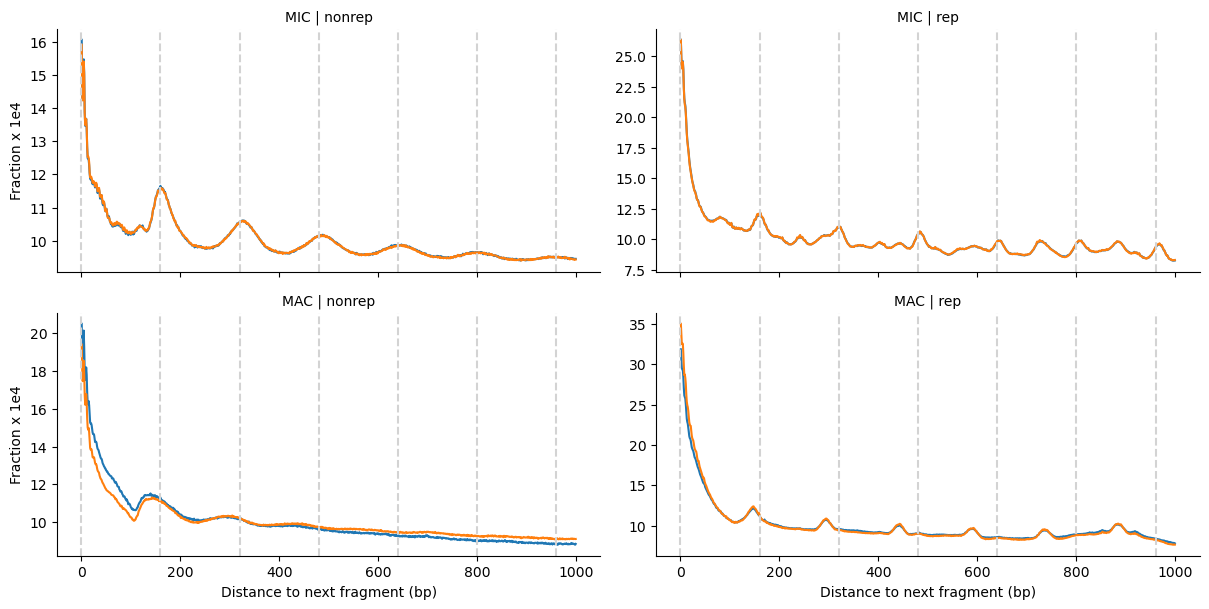

In [15]:
# Global phaseogram
# Show non-repetitive vs. repetitive regions
g = sns.FacetGrid(
    data=pgs_global.query('typ != "sort" and pos>0'), row='nuc', col='typ', aspect=2, sharey=False)
g.map_dataframe(
    sns.lineplot,
    x='pos',
    y='frac_e4',
    hue='lib')
for i in range(7):
    # Vertical lines at multiples of typical nucleosome frag length
    g.map( # seaborn v0.11.2 has FacetGrid.refline for similar functionality
        plt.axvline,
        x=i*160, linestyle='--', color='lightgrey')
g.tight_layout()
g.set_xlabels('Distance to next fragment (bp)')
g.set_ylabels('Fraction x 1e4')
g.set_titles(template="{row_name} | {col_name}")

g.savefig('plots/phaseogram_global.combined.png')
g.savefig('plots/phaseogram_global.combined.pdf')

10 bp periodicity (see fragment length distribution above) not noticeable in the global phaseogram, indicating that it does not affect the prediction of the nucleosome position (using the sequence fragment midpoint method). 

Observations on global phaseogram:
* For non-low-complexity regions: Periodicity at ca. 160 bp observed for MIC but only first (and possibly second) peaks observed for MAC. ==> There is long-range order in MIC but not in MAC
* For low-complexity regions, there is a more complex periodicity pattern with numerous peaks that is difficult to interpret. We suspect that these potentially reflect mapping artefacts (in a repetitive sequence it is potentially ambiguous how to map a read pair if the repeat is shorter than the read or fragment length).

# Fragment length distribution from mapping

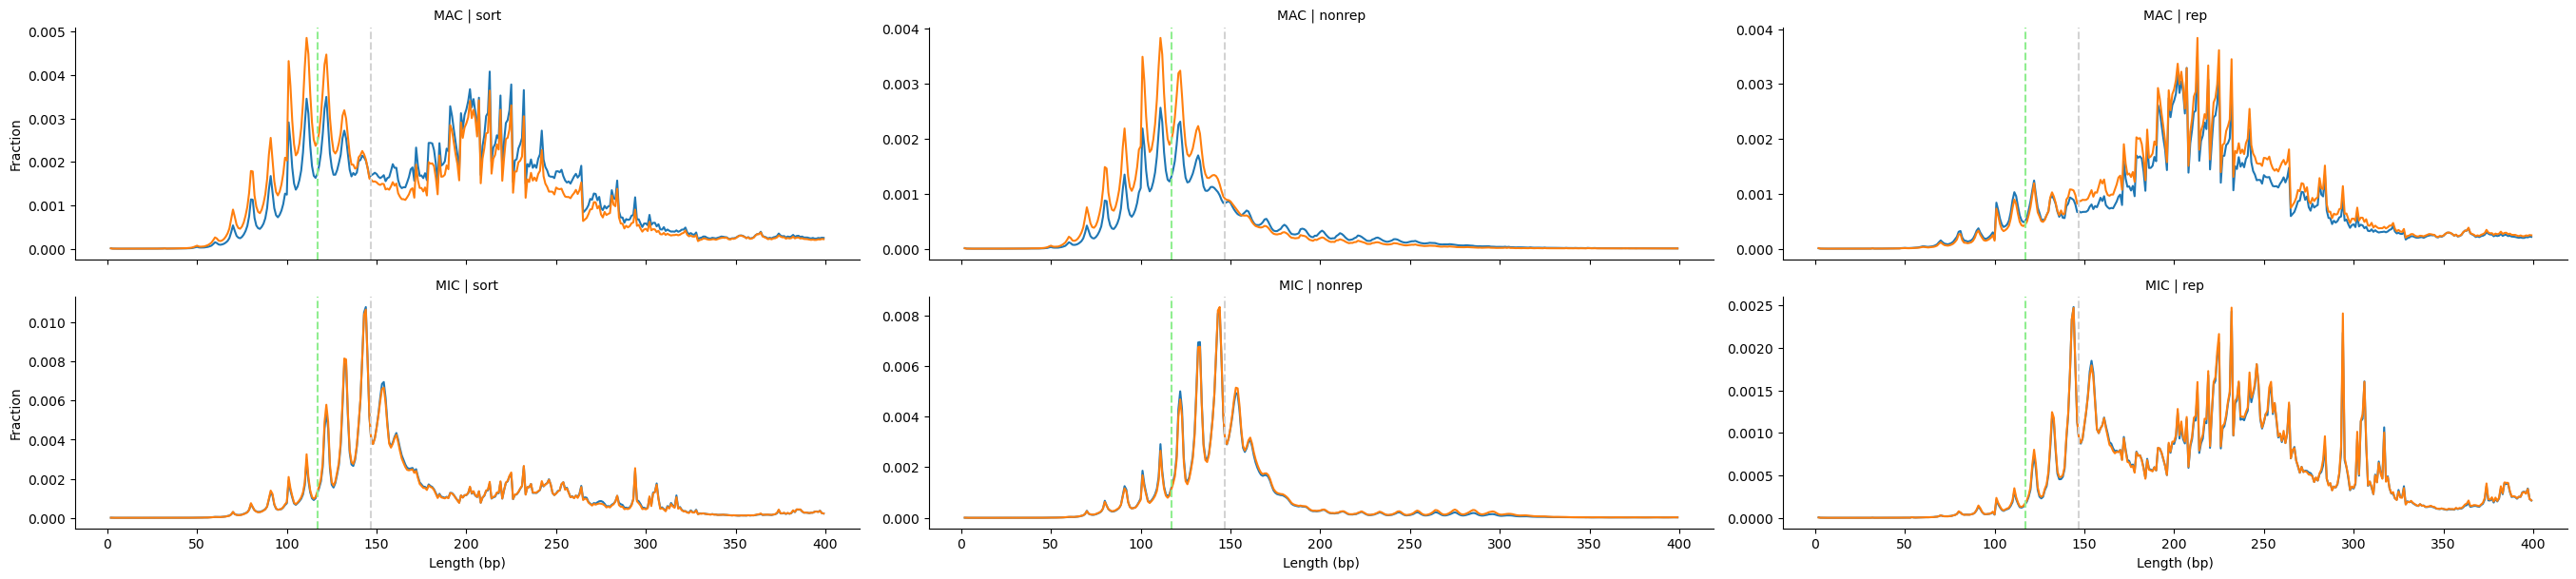

In [16]:
# Mapped template length distribution
# 
# Compare total distribution vs. repetitive and nonrepetitive regions only
g = sns.FacetGrid(
    data=tln.query('pos<400'), row='nuc', col='typ', aspect=3, sharey=False)
g.map_dataframe(
    sns.lineplot,
    x='pos',
    y='frac',
    hue='lib')
g.map( # seaborn v0.11.2 has FacetGrid.refline for similar functionality
    plt.axvline,
    x=147, linestyle='--', color='lightgrey')
g.map(
    plt.axvline,
    x=117, linestyle='--', color='lightgreen')

g.tight_layout()
g.set_xlabels('Length (bp)')
g.set_ylabels('Fraction')
g.set_titles(template="{row_name} | {col_name}")

g.savefig('plots/mapped_reads_length_distribution.png')
g.savefig('plots/mapped_reads_length_distribution.pdf')

Fragments mapping to non-low-complexity regions have fragment size distribution that more closely resembles what we observed in Bioanalyzer traces: mononucleosome peak, fragments slightly shorter in MAC library.

Mappings to low-complexity regions are more difficult to interpret with possible di and tri nucleosome fragments. It is at the moment unclear whether these are mapping artefacts because of the nature of the low complexity repeats.

# Overlay nucleosomal position phaseograms with 6mA modified base counts

Counts of 6mA modified bases relative to CDS start positions have been separately calculated (not in this repository).

See: https://doi.org/10.17617/3.9QTROS

Overlay these on the nucleosomal phaseograms

In [17]:
sixma_mac = pd.read_table(
    "/ebio/abt2_projects/ag-swart-loxodes-raw/data-deposition/annotations/LmagMAC/6mA_ipdSummary/6mA_coverage_relative_to_CDS_start.MAC.txt",
    sep="\s+",
    names=['pos','count']
)
sixma_mic = pd.read_table(
    "/ebio/abt2_projects/ag-swart-loxodes-raw/data-deposition/annotations/LmagMIC/6mA_ipdSummary/6mA_coverage_relative_to_CDS_start.MIC.txt",
    sep="\s+",
    names=['pos','count']
)

In [18]:
# Concatenate the tables
sixma_mac['nuc'] = "MAC"
sixma_mic['nuc'] = "MIC"
sixma = pd.concat([sixma_mac,sixma_mic])
# Coordinates relative to CDS start at 0
sixma['pos'] = sixma['pos'] - 1000

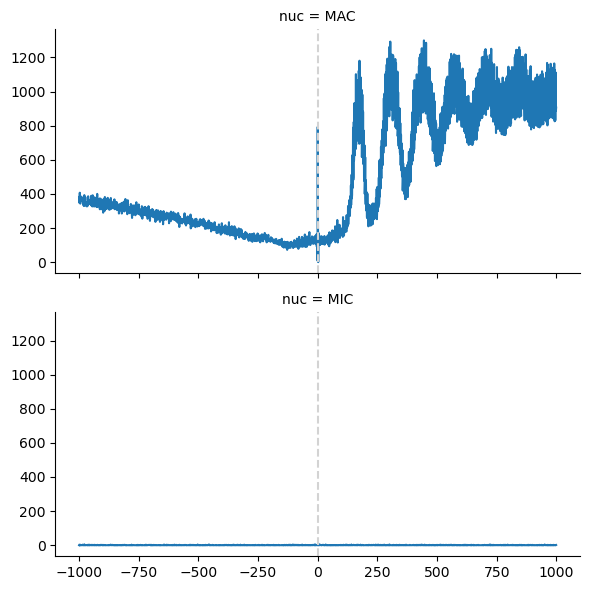

In [19]:
# Plot 6mA modified base counts relative to CDS starts
g = sns.FacetGrid(
    data=sixma, row='nuc', aspect=2)
g.map_dataframe(
    sns.lineplot,
    x='pos',
    y='count')
g.map(
    plt.axvline,
    x=0, linestyle='--', color='lightgrey')
g.tight_layout()

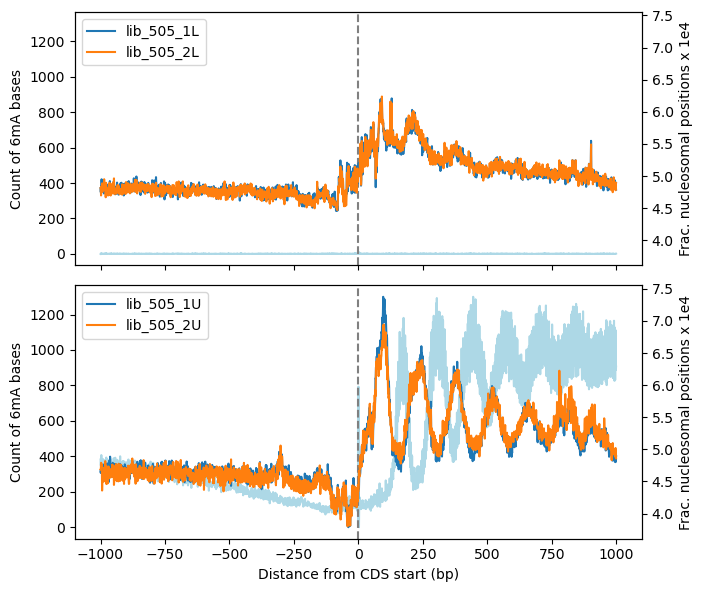

In [20]:
# Overlay nucleosomal position phaseograms and 6mA base counts

fig, axs = plt.subplots(
    2,1, figsize=(7,6),
    sharex=True, 
    sharey=True
)

# Double plot with shared x axes but different y-axes
axs_0_1 = axs[0].twinx()
axs_1_1 = axs[1].twinx()

# MIC
sns.lineplot(
    data=sixma.query('nuc=="MIC"'),
    x="pos", y="count", color='lightblue', ax=axs[0]
)
axs[0].set_ylabel("Count of 6mA bases")
sns.lineplot(
    data=pgs.query('typ == "nonrep"').query('nuc == "MIC"'),
    x="pos", y="frac_e4", hue="lib", ax=axs_0_1
)
axs_0_1.legend(loc='upper left')
axs_0_1.set_ylabel("Frac. nucleosomal positions x 1e4")
axs[0].axvline(x=0,linestyle="--", color="grey")

# MAC
sns.lineplot(
    data=sixma.query('nuc=="MAC"'),
    x="pos", y="count", color='lightblue', ax=axs[1]
)
axs[1].set_ylabel("Count of 6mA bases")
sns.lineplot(
    data=pgs.query('typ == "nonrep"').query('nuc == "MAC"'),
    x="pos", y="frac_e4", hue="lib", ax=axs_1_1
)
axs_1_1.legend(loc='upper left')
axs_1_1.set_ylabel("Frac. nucleosomal positions x 1e4")
axs[1].axvline(x=0,linestyle="--", color="grey")
axs[1].set_xlabel("Distance from CDS start (bp)")

# Set this after lineplot
axs_0_1.set_ylim(axs_1_1.get_ylim()) # MAC plot has wider y-lim

fig.tight_layout()
fig.savefig('plots/phaseogram_gene.6mA_basecounts.combined.png')
fig.savefig('plots/phaseogram_gene.6mA_basecounts.combined.pdf')

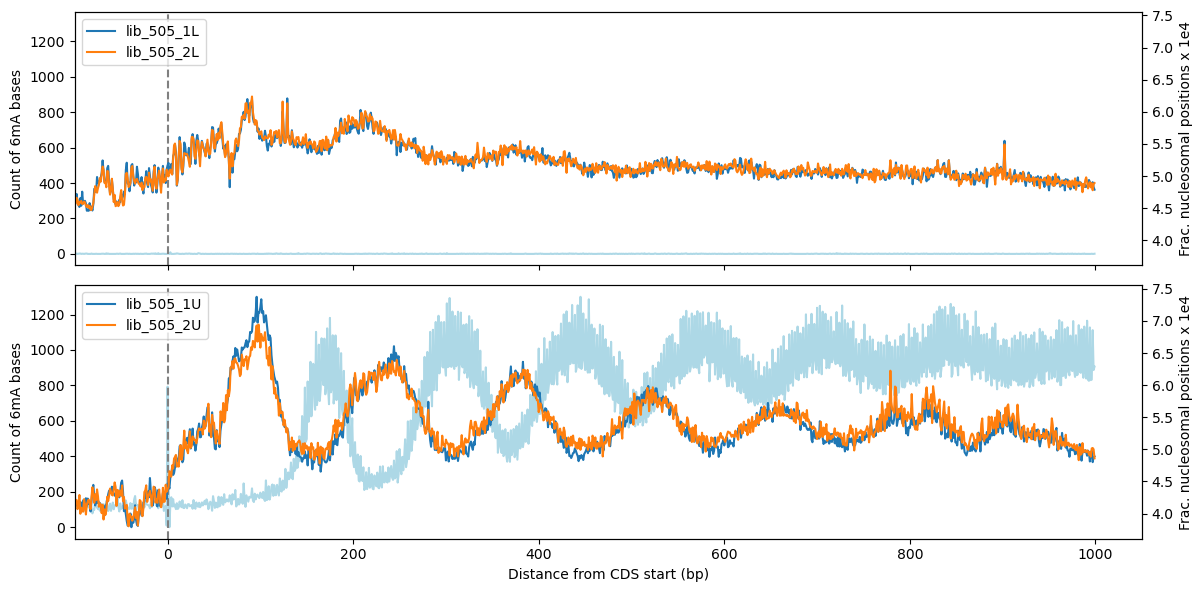

In [21]:
# Stretch out the axes for a closer look
fig, axs = plt.subplots(
    2,1, figsize=(12,6),
    sharex=True, 
    sharey=True
)

# Double plot with shared x axes but different y-axes
axs_0_1 = axs[0].twinx()
axs_1_1 = axs[1].twinx()

# MIC
sns.lineplot(
    data=sixma.query('nuc=="MIC"'),
    x="pos", y="count", color='lightblue', ax=axs[0]
)
axs[0].set_ylabel("Count of 6mA bases")
sns.lineplot(
    data=pgs.query('typ == "nonrep"').query('nuc == "MIC"'),
    x="pos", y="frac_e4", hue="lib", ax=axs_0_1
)
axs_0_1.legend(loc='upper left')
axs_0_1.set_ylabel("Frac. nucleosomal positions x 1e4")
axs[0].axvline(x=0,linestyle="--", color="grey")

# MAC
sns.lineplot(
    data=sixma.query('nuc=="MAC"'),
    x="pos", y="count", color='lightblue', ax=axs[1]
)
axs[1].set_ylabel("Count of 6mA bases")
sns.lineplot(
    data=pgs.query('typ == "nonrep"').query('nuc == "MAC"'),
    x="pos", y="frac_e4", hue="lib", ax=axs_1_1
)
axs_1_1.legend(loc='upper left')
axs_1_1.set_ylabel("Frac. nucleosomal positions x 1e4")
axs[1].axvline(x=0,linestyle="--", color="grey")
axs[1].set_xlabel("Distance from CDS start (bp)")

# Set this after lineplot
axs_0_1.set_ylim(axs_1_1.get_ylim()) # MAC plot has wider y-lim

axs[0].set_xlim(-100,1050)

axs[1].set_xlim(-100,1050)

fig.tight_layout()
fig.savefig('plots/phaseogram_gene.6mA_basecounts.combined.detail.png')
fig.savefig('plots/phaseogram_gene.6mA_basecounts.combined.detail.pdf')

Observe that the nucleosome positioning and 6mA modified bases are anti-correlated, as also observed in other ciliates like Tetrahymena. 